<a href="https://colab.research.google.com/github/ThesanR/TorontoPermitClassification/blob/main/PermitClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of Permit applications from the City of Toronto between the years 2010 and 2023.

In [ ]:
# 1. Installing Pycaret modules for ML analysis
!pip install pycaret[analysis]
!pip install pycaret[models]
!pip install pycaret[tuner]
!pip install pycaret[mlops]
!pip install pycaret[parallel]
!pip install pycaret[test]

In [ ]:
# 2. Importing relevant libraries to analyze data.
import pandas as pd
import numpy as np
import catboost
from catboost import Pool

In [ ]:
# 3. Importing datasets directly from the City of Toronto Open data site.

#2015 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/fbceeefc-a24d-43d0-8009-a1ec872550d0/download/Cleared%20Permits%202015.zip
!unzip -q "Cleared Permits 2015.zip"
#2016 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/b6f1907e-5a45-43f7-8c3c-56e4edc4f42f/download/Cleared%20Permits%202016.zip
!unzip -q "Cleared Permits 2016.zip"
#2017-2023 Cleared Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/building-permits-cleared-permits/resource/23de66da-ed1a-434a-a0fa-d85ec55f8f20/download/Cleared%20Building%20Permits%20since%202017.csv
#Active Permits
!wget -q https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/108c2bd1-6945-46f6-af92-02f5658ee7f7/resource/dfce3b7b-4f17-4a9d-9155-5e390a5ffa97/download/building-permits-active-permits.csv

In [ ]:
# 4. Setting variables for imported CSV files. Setting POSTAL column to string and Revision number to str to reduce computation due to improper source file formatting.
df2015 = pd.read_csv('clearedpermits2015.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2016 = pd.read_csv('clearedpermits2016.csv', dtype={"POSTAL": str, "REVISION_NUM": str})
df2017_2023 = pd.read_csv('Cleared Building Permits since 2017.csv', dtype={"POSTAL": str, "REVISION_NUM": str})

# 5. Concatenating CSV files into one dataframe.
df = pd.concat([df2015, df2016, df2017_2023], ignore_index=True, sort=False)

# 6. Dropping rows that have bad data such as permit statuses that are not closed, estimated construction costs that are not numbers, null values.
#    Updating dataframe to have 8 columns for proposed features and target vector (To be constructed based on transformed data from the application data and issued date columns).
df = df.drop(df[(df.EST_CONST_COST == "DO NOT UPDATE OR DELETE THIS INFO FIELD") | (df.STATUS != "Closed")].index)
df = df[['PERMIT_NUM', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK', 'APPLICATION_DATE', 'ISSUED_DATE', 'EST_CONST_COST']]
df = df.dropna()

# 7. Formatting estimated construction cost column to be only integers by purging commas and rows with values less than $100.
dftemp = (df['EST_CONST_COST'].replace(",","", regex=True)).astype(float)
df = df.drop('EST_CONST_COST', axis=1)
df = pd.concat([df, dftemp], axis=1)
df = df.drop(df[df.EST_CONST_COST < 100].index)

# 8. Getting value counts from permit type, work, and structure type. Removing value counts less than a particular threshold to have a small set of highly populated types rather than a large set of varied data.
df = df[~df['PERMIT_TYPE'].isin((df['PERMIT_TYPE'].value_counts())[(df['PERMIT_TYPE'].value_counts()) < 500].index)]
df = df[~df['WORK'].isin((df['WORK'].value_counts())[(df['WORK'].value_counts()) < 1000].index)]
df = df[~df['STRUCTURE_TYPE'].isin((df['STRUCTURE_TYPE'].value_counts())[(df['STRUCTURE_TYPE'].value_counts()) < 500].index)]
# 8a. Removing duplicate permit numbers.
df = df[~df['PERMIT_NUM'].isin((df['PERMIT_NUM'].value_counts())[(df['PERMIT_NUM'].value_counts()) > 1].index)]

# 8b. Viewing value counts.
#print(df.PERMIT_NUM.value_counts(), "\n")
#print(df.POSTAL.value_counts(), "\n")
#print(df.PERMIT_TYPE.value_counts(), "\n")
#print(df.WORK.value_counts(),"\n")
#print(df.STRUCTURE_TYPE.value_counts(), "\n")

# 9. Extracting year from permit number (First two digits) for years above and below 2000. Creating new column for application year.
perm_num_temp = 2000 + (df['PERMIT_NUM'].astype(str).str[0:2]).astype(int)
perm_num_temp = perm_num_temp - 100*(perm_num_temp > 2050)
app_num_temp = (df['APPLICATION_DATE'].astype(str).str[0:4]).astype(int)
# 9a. Checking for consistency in year between permit number year and applied year. Values that do not match are assigned a year of 0 to be filered out by the application year cutoff (In this case, 2010).
app_year = pd.DataFrame({'APPLICATION_YEAR' : perm_num_temp*(perm_num_temp == app_num_temp)})
df = pd.concat([app_year, df], axis=1)
df = df.drop(df[df.APPLICATION_YEAR < 2010].index)

# 10. Converting date entries to recognized datetime format in python.
app_datetime = pd.to_datetime(pd.DataFrame({'year' : df['APPLICATION_DATE'].astype(str).str[0:4], 'month' : df['APPLICATION_DATE'].astype(str).str[5:7], 'day' : df['APPLICATION_DATE'].astype(str).str[8:10]}))
issue_datetime = pd.to_datetime(pd.DataFrame({'year' : df['ISSUED_DATE'].astype(str).str[0:4], 'month' : df['ISSUED_DATE'].astype(str).str[5:7], 'day' : df['ISSUED_DATE'].astype(str).str[8:10]}))
# 10a. Calculating process time by subtracting application date from issue date.
app_time_days = pd.to_timedelta((issue_datetime - app_datetime), unit='d')
app_time_days = pd.DataFrame({'TIME_DAYS' : (app_time_days.astype(str).str[0:-5]).astype(int)})
app_time = app_time_days.astype(str)
app_time = app_time.rename(columns={'TIME_DAYS' : 'PROCESS_TIME'})


# 11. Creating equal sized bins for target vector out of process time. (Aiming for 3 classes: short, medium, and long projects)
#x = pd.qcut(x=app_time_days['TIME_DAYS'], q=3, precision=0)
#print(x.value_counts(), "\n")

# 11a. Output from previous lines yields bins of 0-2 weeks, 2-5 weeks, and over 5 weeks. Using these thresholds to split the dataset into three later on.

app_time['PROJECT_TYPE'] = pd.cut(x=app_time_days['TIME_DAYS'], bins=[0, 14, 37, float("inf")],
                                labels=['WITHIN 2 WEEKS', '2-5 WEEKS', 'OVER 5 WEEKS'],
                                include_lowest=True)

'''
app_time['PROCESS_TIME'] = pd.cut(x=app_time_days['TIME_DAYS'], bins=[0, 7, 31, 91, 183, 365, 730, float("inf")],
                                labels=['0-7 DAYS', '1-4 WEEKS', '1-3 MONTHS', '3-6 MONTHS', '6-12 MONTHS', '1-2 YEARS', 'OVER 2 YEARS'],
                                include_lowest=True)
'''

# 12. Drop original columns (Permit number, Application date, Issued date) that will be replaced by the transformed data (Application year, process time).
year_float = df.APPLICATION_YEAR.astype(float)

# 12a. Formatting categorical data for ML processing.
dfbinaries = (pd.get_dummies(df[{'PERMIT_TYPE','STRUCTURE_TYPE','WORK'}], prefix = ['PT','ST','W'])).astype(float)
df = df.drop(['APPLICATION_YEAR', 'PERMIT_NUM', 'APPLICATION_DATE', 'ISSUED_DATE', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK'], axis=1)

df = pd.concat([year_float, dfbinaries, df, app_time], axis=1)
# 12b. Dropping null values.
df = df.dropna()


#dfTEST = df[~df['PERMIT_TYPE'].isin((df['PERMIT_TYPE'].value_counts())[(df['PERMIT_TYPE'].value_counts()) < 500].index)]

# 12b. Dropping columns to test classification.
#df = df.drop(['PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK'], axis=1)
#df = df.drop(['APPLICATION_YEAR', 'POSTAL', 'EST_CONST_COST'], axis=1)

# 13. Printing cleaned data.
df



,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST,PROCESS_TIME,PROJECT_TYPE
4762,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4000.0,14,WITHIN 2 WEEKS
4763,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.0,11,WITHIN 2 WEEKS
4771,2010.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0,10,WITHIN 2 WEEKS
4773,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,330000.0,136,OVER 5 WEEKS
4779,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35000.0,1,WITHIN 2 WEEKS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339058,2023.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3000.0,15,2-5 WEEKS
339080,2023.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15000.0,5,WITHIN 2 WEEKS
339134,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000.0,12,WITHIN 2 WEEKS
339142,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2900.0,8,WITHIN 2 WEEKS


In [ ]:
# FOR SHORT PROJECTS

dfshort = df.drop(df[df.PROJECT_TYPE != "WITHIN 2 WEEKS"].index)
#print(dfshort['PROCESS_TIME'].value_counts(), "\n")
x = dfshort['PROCESS_TIME'].astype(int)
#Setting threshold to 8 days
x = pd.qcut(x=x, q=2, labels=[0, 1], precision=0)
x = x.astype(int)
#x = pd.DataFrame({'PROCESS_TIME' : x})
print(x.value_counts(), "\n")
dfshort = dfshort.drop(['PROCESS_TIME', 'PROJECT_TYPE'], axis=1)
dfshort = pd.concat([dfshort, x], axis=1)
dfshort

0    14269
1     9731
Name: PROCESS_TIME, dtype: int64 



,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_SFD - Townhouse,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST,PROCESS_TIME
4762,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4000.0,1
4763,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1000.0,1
4771,2010.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0,1
4779,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,35000.0,0
4781,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339052,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,25000.0,0
339080,2023.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15000.0,0
339134,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000.0,1
339142,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2900.0,0


In [ ]:
# FOR MEDIUM PROJECTS

dfmedium = df.drop(df[df.PROJECT_TYPE != "2-5 WEEKS"].index)
#print(dfmedium['PROCESS_TIME'].value_counts(), "\n")
x = dfmedium['PROCESS_TIME'].astype(int)
#Setting threshold to 25 days
x = pd.qcut(x=x, q=2, labels=[0, 1], precision=0)
x = x.astype(int)
print(x.value_counts(), "\n")
dfmedium = dfmedium.drop(['PROCESS_TIME', 'PROJECT_TYPE'], axis=1)
dfmedium = pd.concat([dfmedium, x], axis=1)
dfmedium

0    13025
1    11711
Name: PROCESS_TIME, dtype: int64 



,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_SFD - Townhouse,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST,PROCESS_TIME
4795,2010.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3500.0,0
4796,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6000.0,1
4800,2010.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0,1
4802,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,10000.0,1
4805,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,15000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338767,2023.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15000.0,1
338817,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10000.0,0
338909,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30000.0,0
339001,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1300.0,0


In [ ]:
# FOR LONG PROJECTS

dflong = df.drop(df[df.PROJECT_TYPE != "OVER 5 WEEKS"].index)
#print(dflong['PROCESS_TIME'].value_counts(), "\n")
x = dflong['PROCESS_TIME'].astype(int)
#Setting threshold to 74 days.
x = pd.qcut(x=x, q=2, labels=[0, 1], precision=0)
x = x.astype(int)
print(x.value_counts(), "\n")
dflong = dflong.drop(['PROCESS_TIME', 'PROJECT_TYPE'], axis=1)
dflong = pd.concat([dflong, x], axis=1)
dflong

0    11765
1    11619
Name: PROCESS_TIME, dtype: int64 



,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_SFD - Townhouse,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST,PROCESS_TIME
4773,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,330000.0,1
4792,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,30000.0,0
4799,2010.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0,1
4823,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,110603.0,1
4826,2010.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,114063.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337964,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4000.0,0
338093,2023.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,20000.0,0
338104,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,50000.0,0
338235,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8100.0,0


In [ ]:
# INITIALIZING ML PROCESSING WITH PYCARET SETUP FUNCTION.

from pycaret.classification import *
s_short = setup(dfshort, target = 'PROCESS_TIME', session_id = 1)
s_medium = setup(dfmedium, target = 'PROCESS_TIME', session_id = 2)
s_long = setup(dflong, target = 'PROCESS_TIME', session_id = 3)

,Description,Value
0,Session id,1
1,Target,PROCESS_TIME
2,Target type,Binary
3,Original data shape,"(24000, 44)"
4,Transformed data shape,"(24000, 44)"
5,Transformed train set shape,"(16800, 44)"
6,Transformed test set shape,"(7200, 44)"
7,Numeric features,43
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,2
1,Target,PROCESS_TIME
2,Target type,Binary
3,Original data shape,"(24736, 44)"
4,Transformed data shape,"(24736, 44)"
5,Transformed train set shape,"(17315, 44)"
6,Transformed test set shape,"(7421, 44)"
7,Numeric features,43
8,Preprocess,True
9,Imputation type,simple


,Description,Value
0,Session id,3
1,Target,PROCESS_TIME
2,Target type,Binary
3,Original data shape,"(23384, 44)"
4,Transformed data shape,"(23384, 44)"
5,Transformed train set shape,"(16368, 44)"
6,Transformed test set shape,"(7016, 44)"
7,Numeric features,43
8,Preprocess,True
9,Imputation type,simple


In [ ]:
#COMPARING MODELS FOR SHORT PROJECTS

best_short = s_short.compare_models()
#best = create_model('lightgbm')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.6554,0.6855,0.4564,0.5985,0.5177,0.2571,0.2629,9.0120
gbc,Gradient Boosting Classifier,0.6523,0.6868,0.4338,0.5986,0.5028,0.2459,0.2535,1.5670
lightgbm,Light Gradient Boosting Machine,0.6521,0.6828,0.4501,0.5939,0.5118,0.2495,0.2555,0.7770
ada,Ada Boost Classifier,0.6492,0.6815,0.3868,0.6058,0.4719,0.2280,0.2410,0.9430
xgboost,Extreme Gradient Boosting,0.6474,0.6732,0.4607,0.5828,0.5144,0.2435,0.2478,0.5490
ridge,Ridge Classifier,0.6429,0.0000,0.3658,0.5977,0.4537,0.2106,0.2248,0.1190
lda,Linear Discriminant Analysis,0.6427,0.6764,0.3705,0.5957,0.4567,0.2115,0.2249,0.3030
rf,Random Forest Classifier,0.6114,0.6269,0.4523,0.5245,0.4856,0.1762,0.1775,1.8650
et,Extra Trees Classifier,0.6098,0.6109,0.4118,0.5243,0.4612,0.1622,0.1652,1.8910
knn,K Neighbors Classifier,0.6086,0.6154,0.4536,0.5202,0.4844,0.1714,0.1726,0.5750


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [187]:
#COMPARING MODELS FOR MEDIUM PROJECTS

#best_medium = s_medium.compare_models()
best_medium = s_medium.create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5941,0.6283,0.3963,0.6098,0.4804,0.1713,0.1820
1,0.5895,0.6234,0.4329,0.5907,0.4996,0.1654,0.1712
2,0.5895,0.6240,0.4317,0.5910,0.4989,0.1653,0.1712
3,0.5814,0.5959,0.3939,0.5862,0.4712,0.1463,0.1543
4,0.5699,0.5950,0.3500,0.5752,0.4352,0.1199,0.1296
5,0.5910,0.6083,0.4098,0.6000,0.4870,0.1665,0.1749
6,0.5869,0.6191,0.4268,0.5882,0.4947,0.1601,0.1660
7,0.5835,0.6092,0.3963,0.5898,0.4741,0.1507,0.1589
8,0.5754,0.6003,0.3895,0.5758,0.4647,0.1340,0.1411


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [188]:
#COMPARING MODELS FOR LONG PROJECTS

#best_long = s_long.compare_models()
best_long = s_long.create_model('catboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6500,0.6937,0.5707,0.6744,0.6183,0.2992,0.3027
1,0.6249,0.6852,0.5424,0.6457,0.5896,0.2490,0.2522
2,0.6310,0.7056,0.5547,0.6508,0.5989,0.2613,0.2642
3,0.6451,0.6894,0.5756,0.6648,0.6170,0.2895,0.2921
4,0.6396,0.6961,0.5695,0.6586,0.6108,0.2785,0.2810
5,0.6494,0.7225,0.5897,0.6667,0.6258,0.2983,0.3002
6,0.6420,0.6997,0.5479,0.6717,0.6035,0.2833,0.2882
7,0.6457,0.7082,0.5614,0.6721,0.6118,0.2907,0.2947
8,0.6278,0.6842,0.5560,0.6457,0.5975,0.2548,0.2573


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

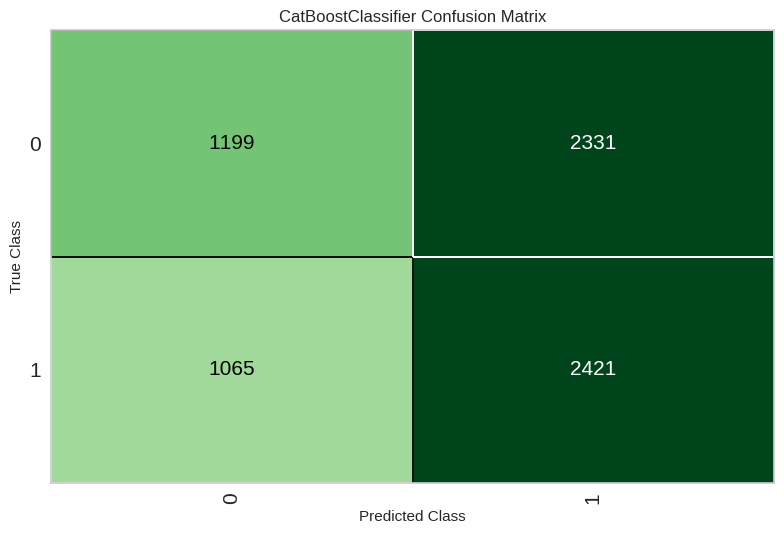

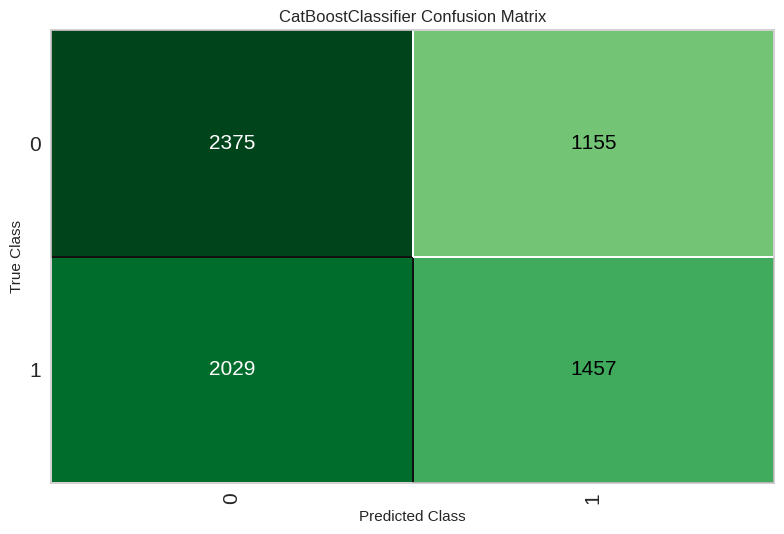

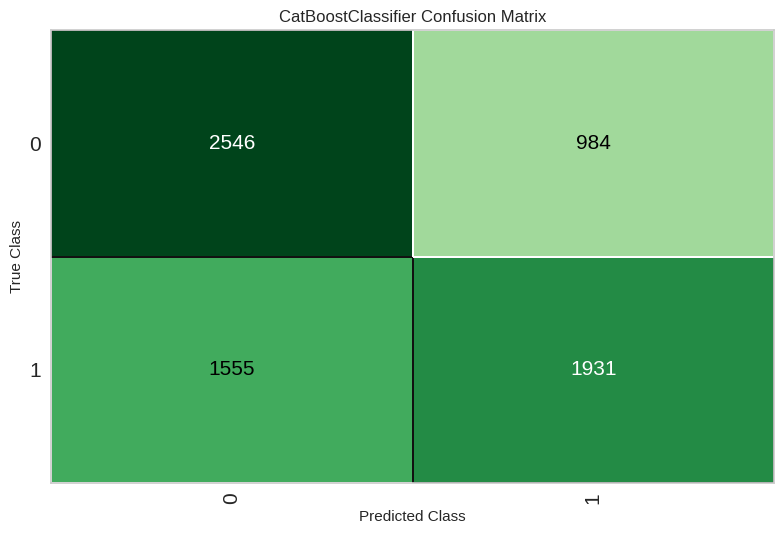

In [189]:
#PLOTTING CONFUSION MATRICES FOR EACH PROJECT TYPE

conf_short = plot_model(best_short, plot = 'confusion_matrix')
conf_medium = plot_model(best_medium, plot = 'confusion_matrix')
conf_long = plot_model(best_long, plot = 'confusion_matrix')

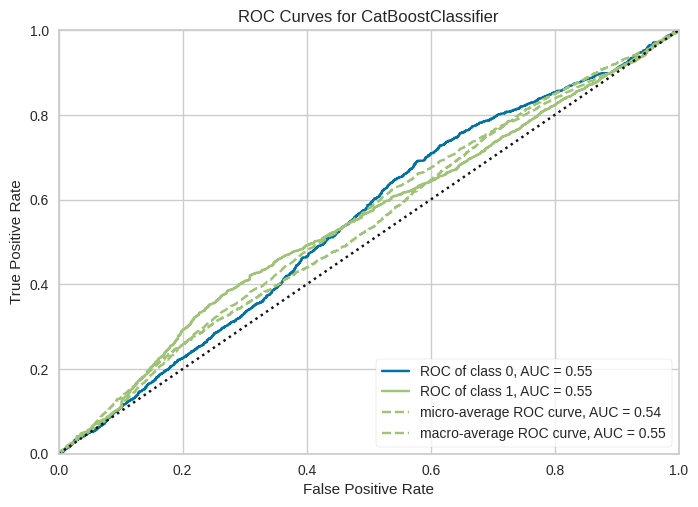

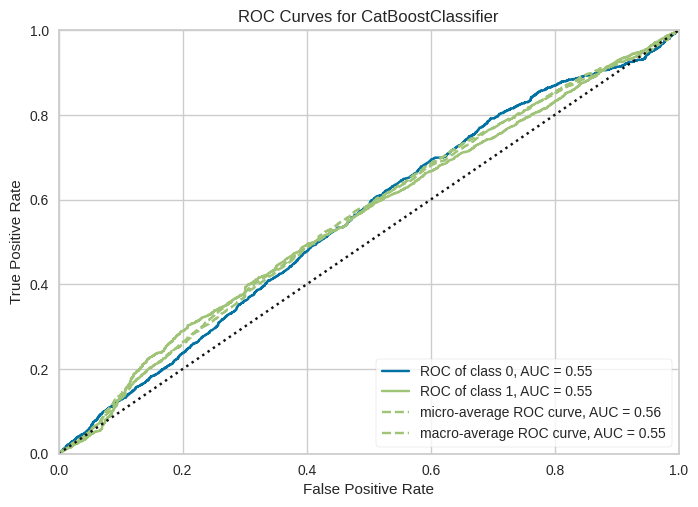

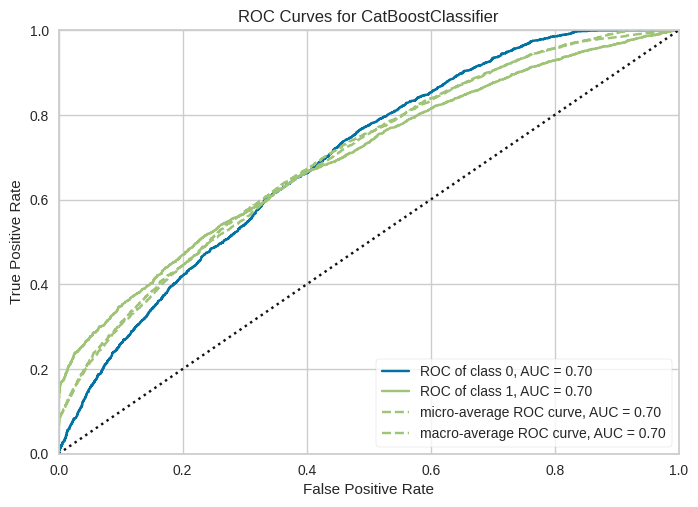

In [190]:
# PLOTTING ROC CURVES

plot_model(best_short, plot = 'auc')
plot_model(best_medium, plot = 'auc')
plot_model(best_long, plot = 'auc')

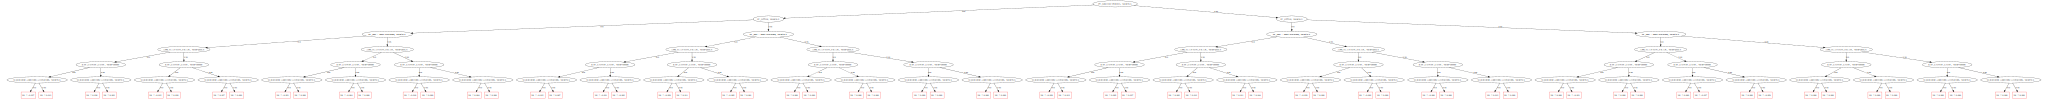

In [191]:
X = dfshort.drop(['PROCESS_TIME'], axis=1)
y = dfshort['PROCESS_TIME']

is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]
pool_short = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))
best_short.plot_tree(tree_idx=0, pool=pool_short)


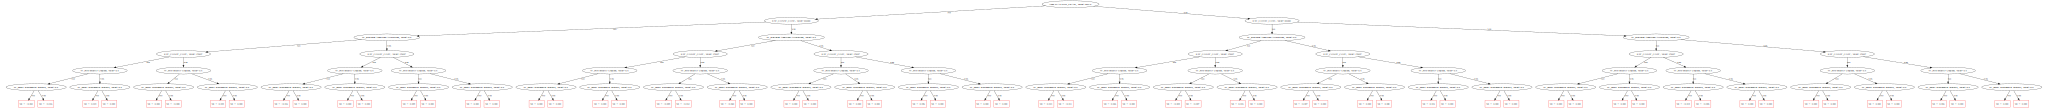

In [192]:
X = dfmedium.drop(['PROCESS_TIME'], axis=1)
y = dfmedium['PROCESS_TIME']

is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]
pool_medium = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))
best_medium.plot_tree(tree_idx=0, pool=pool_medium)

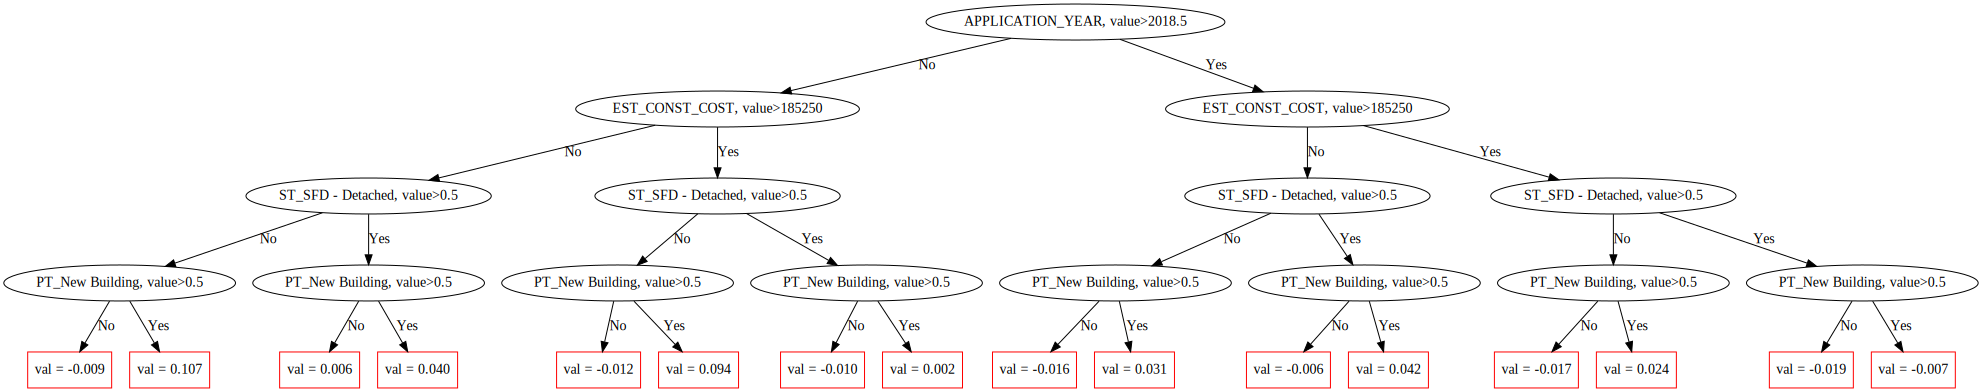

In [193]:
X = dflong.drop(['PROCESS_TIME'], axis=1)
y = dflong['PROCESS_TIME']

is_cat = (X.dtypes != float)
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]
pool_long = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))
best_long.plot_tree(tree_idx=0, pool=pool_long)

In [194]:
#SAVING MODELS LOCALLY

save_model(best_short, 'PermitTime1')
save_model(best_medium, 'PermitTime2')
save_model(best_long, 'PermitTime3')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['APPLICATION_YEAR',
                                              'PT_ Backflow Prevention Devices '
                                              '(Water only)',
                                              'PT_Addition(s) ', 'PT_Deck',
                                              'PT_Electromagnetic Locks',
                                              'PT_Fire Alarm', 'PT_Garage',
                                              'PT_Interior Alterations',
                                              'PT_Multiple Projects',
                                              'PT_New Building', 'PT_Other(BA)',
                                              'PT_Other(PS)', 'PT_Ot...
                                     transformer=SimpleImputer(add_indicator=False,
                                                       

In [195]:

# FOR NEW SAMPLE DATA WITHOUT CLASS (PREDICTION)

dfc = pd.read_csv('building-permits-active-permits.csv', usecols=['PERMIT_NUM','PERMIT_TYPE','STRUCTURE_TYPE','WORK','POSTAL','APPLICATION_DATE','ISSUED_DATE','STATUS','EST_CONST_COST'],
                  dtype={"POSTAL": str, "EST_CONST_COST": str})

dfc = dfc.drop(dfc[(dfc.STATUS != "Under Review") & (dfc.STATUS != "Application Received") & (dfc.STATUS != "Not Started")].index)
dfc = dfc[['PERMIT_NUM', 'PERMIT_TYPE', 'STRUCTURE_TYPE', 'WORK', 'APPLICATION_DATE', 'ISSUED_DATE', 'EST_CONST_COST']]
dfc = dfc.drop(dfc[pd.notna(dfc.ISSUED_DATE)].index)
dfc = dfc.drop('ISSUED_DATE', axis=1)
dfc = dfc.dropna()

dfc = dfc.drop(dfc[(dfc.EST_CONST_COST == "DO NOT UPDATE OR DELETE THIS INFO FIELD")].index)
dfctemp = ((dfc['EST_CONST_COST'].replace(",","", regex=True)).astype(float))
dfc = dfc.drop('EST_CONST_COST', axis=1)
dfc = pd.concat([dfc, dfctemp], axis=1)
dfc = dfc.drop(dfc[dfc.EST_CONST_COST < 100].index)

dfc = dfc[~dfc['PERMIT_NUM'].isin((dfc['PERMIT_NUM'].value_counts())[(dfc['PERMIT_NUM'].value_counts()) > 1].index)]

perm_num_temp = 2000 + (dfc['PERMIT_NUM'].astype(str).str[0:2]).astype(int)
perm_num_temp = perm_num_temp - 100*(perm_num_temp > 2050)
app_num_temp = (dfc['APPLICATION_DATE'].astype(str).str[0:4]).astype(int)
# Checking for consistency in year between permit number year and applied year. Values that do not match are assigned a year of 0
#to be filered out by the application year cutoff (In this case, recent applications after 2020).
app_year = (pd.DataFrame({'APPLICATION_YEAR' : perm_num_temp*(perm_num_temp == app_num_temp)})).astype(float)
dfc = pd.concat([app_year, dfc], axis=1)
dfc = dfc.drop(dfc[dfc.APPLICATION_YEAR < 2021].index)

#FORMAT CATEGORICAL DATA INTO BINARY FOR ML PROCESSING.
dfcbinaries = (pd.get_dummies(dfc[{'PERMIT_TYPE','STRUCTURE_TYPE','WORK'}], prefix = ['PT','ST','W'])).astype(float)

dfcbinaries = pd.DataFrame(data=dfcbinaries, index=dfcbinaries.index, columns=dfbinaries.columns)
dfcbinaries = dfcbinaries.fillna(0)

# Drop original columns (Permit number, Application date) that will be replaced by the transformed data (Application year).
dfc = dfc.drop(['PERMIT_NUM', 'APPLICATION_DATE'], axis=1)
# Dropping null values.
dfc = dfc.dropna()

dfc = pd.concat([dfc['APPLICATION_YEAR'], dfcbinaries, dfc['EST_CONST_COST']], axis=1)
#Printing cleaned data.
dfc

,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_SFD - Semi-Detached,ST_SFD - Townhouse,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST
213943,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35000.0
218745,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70000.0
222692,2022.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0
224797,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40000.0
229579,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254757,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2800.0
254777,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20000.0
254786,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4700.0
254806,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150000.0


In [196]:
#PREDICTIONS USING SHORT PROJECT MODEL (0 if less than 8 days, 1 if greater than 8 days)
pred_short = predict_model(best_short, data = dfc)
pred_short

,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST,prediction_label,prediction_score
213943,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35000.0,0,0.5534
218745,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70000.0,1,0.5004
222692,2022.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0,0,0.6025
224797,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40000.0,1,0.6401
229579,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,0,0.5239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254757,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2800.0,0,0.5662
254777,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20000.0,0,0.8275
254786,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4700.0,0,0.9197
254806,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150000.0,1,0.5278


In [197]:
#PREDICTIONS USING MEDIUM PROJECT MODEL (0 if less than 25 days, 1 if greater than 25 days)
pred_medium = predict_model(best_medium, data = dfc)
pred_medium

,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST,prediction_label,prediction_score
213943,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35000.0,1,0.6573
218745,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70000.0,1,0.5582
222692,2022.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0,1,0.5880
224797,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40000.0,0,0.6364
229579,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,1,0.5150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254757,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2800.0,1,0.5602
254777,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20000.0,1,0.6147
254786,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4700.0,1,0.8367
254806,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150000.0,0,0.6974


In [199]:
#PREDICTIONS USING LONG PROJECT MODEL (0 if less than 74 days, 1 if greater than 74 days)
pred_long = predict_model(best_long, data = dfc)
pred_long

,APPLICATION_YEAR,PT_ Backflow Prevention Devices (Water only),PT_Addition(s),PT_Deck,PT_Electromagnetic Locks,PT_Fire Alarm,PT_Garage,PT_Interior Alterations,PT_Multiple Projects,PT_New Building,...,ST_Stacked Townhouses,W_Building Additions/Alterations,W_Fire/Security Upgrade,W_New Building,W_New Houses,W_Plumbing(PS),W_Small Residential Projects,EST_CONST_COST,prediction_label,prediction_score
213943,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,35000.0,0,0.6134
218745,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,70000.0,0,0.8547
222692,2022.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5000.0,0,0.7072
224797,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,40000.0,0,0.6211
229579,2022.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10000.0,0,0.7058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254757,2023.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2800.0,0,0.5891
254777,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20000.0,0,0.9238
254786,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4700.0,0,0.8701
254806,2023.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,150000.0,0,0.8305


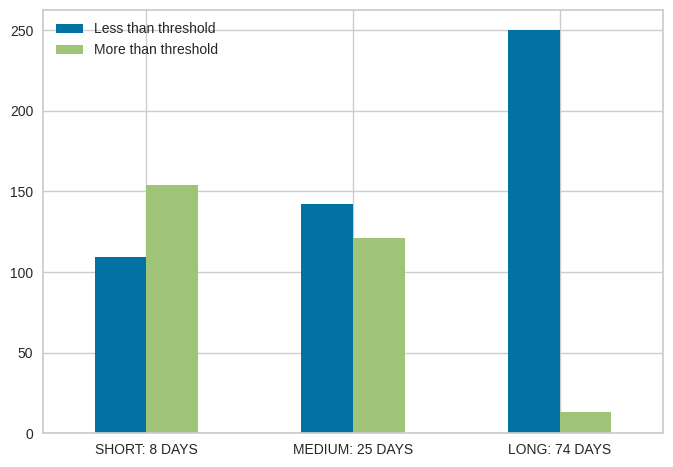

In [215]:
values_0 = [(pred_short['prediction_label'].value_counts())[0], (pred_medium['prediction_label'].value_counts())[0], (pred_long['prediction_label'].value_counts())[0]]
values_1 = [(pred_short['prediction_label'].value_counts())[1], (pred_medium['prediction_label'].value_counts())[1], (pred_long['prediction_label'].value_counts())[1]]
index = ['SHORT: 8 DAYS', 'MEDIUM: 25 DAYS', 'LONG: 74 DAYS']
dfbarplot = pd.DataFrame({'Less than threshold': values_0, 'More than threshold': values_1}, index=index)
ax = dfbarplot.plot.bar(rot=0)